# Bucket Pricing

The main idea is to clean the distributions of the categories included in the data (each CategoryDesc and Manufacturer will be considered as a different category), to create groups of similar categories using the **Kolmogorov-Smirnoff test**.

Then, having groups of similar categories, create buckets for the ones that has not too much variance.

#  Libraries

In [1]:
library(ggplot2)
library(dplyr)
library(forcats)
library(readr)
library(factoextra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



# Read Data

In [2]:
data <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  sold_price = col_double(),
  tax = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  Inventory_Days = col_double()
)

See spec(...) for full column specifications.

Warning message:
“1 parsing failure.
   row  col expected actual                                                                  file
386161 cost a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data.csv'
”


In [3]:
data$date <- substr(data$origindate,1,10) %>% as.Date

Example of 1 row of the data

In [4]:
head(data,1) %>% t

[,1]                              
Country             USA                               
primary_relation    423090953                         
gid                 NULL                              
origindate          2020-05-16 15:15:13 +0000         
FiscalYear          2020                              
original_price      124.9899978637695                 
sold_price          81                                
tax                 0                                 
Item_ezid           180280165137                      
ItemID              480451189                         
cost                50                                
item_categorization 621003                            
Primary             General Merchandise               
Secondary           Tools                             
Tertiary            Power Tool                        
CategoryDesc        Circular Saw (No Special Features)
item_type           GM                                
store               18028                             
transType           Sales                             
customerType        No Customer                       
Inventory_Days      201                               
Manufacturer        PORTER-CABLE                      
Model_Number        324MAG                            
item_cond           A                                 
date                2020-05-16

# Cleaning  Data

## Drop big categories

The business wants buckets for "other stuff", so it will be dropped categories like:
 - TVs
 - Videogames
 - Tablets
 - Cellphones
 - Laptop

In [5]:
x <- c(
'Video Game Console',
'Laptop',
'LED',
'Digital OLED TVs',
'LCD',
'Tablet',
'Smart Phones',
'Cellular Telephone',
'NULL')

In [6]:
data %>%
 filter(!(CategoryDesc %in% x)) -> data

## Sold price > 5 dlls

For the business, every item sold <= 5 dlls has no importance, so will be filtered

In [7]:
data %>%
 filter(sold_price > 5) -> data

## 90B

Keep just items with ItemCondition B, sold in the first 90 days (without disccount), to be comparable

In [8]:
data %>%
 filter(item_cond == 'B',
        Inventory_Days <= 90) -> data

## LTV filter

Just items with LTV between 20% and 80%

In [9]:
data %>%
 mutate(LTV = cost/sold_price) %>%
 filter(LTV >= 0.2, LTV <= 0.8) -> data

## Create Category

Paste the Manufacturer and the CategoryDesc to create the Categories

In [10]:
data %>%
 mutate(CategoryDesc_original = CategoryDesc,
        CategoryDesc          = paste0(Manufacturer,'-',CategoryDesc)) -> data

## 30 items

To have reasonable distributions, only will be considered CategoryDesc with at least 30 items

In [11]:
l <- nrow(data)
uc <- unique(data$CategoryDesc) %>% length

paste0('The original data has ', scales::comma(l), ' rows, with ', uc, ' different CategoryDesc')

[1] "The original data has 320,147 rows, with 42099 different CategoryDesc"

In [12]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(n = n()) %>%
 filter(n >= 30) %>%
 select(-n) -> data

In [13]:
l <- nrow(data)
uc <- unique(data$CategoryDesc) %>% length

paste0('The data with representative CategoryDesc has ', scales::comma(l), ' rows, with ', uc, ' different CategoryDesc')

[1] "The data with representative CategoryDesc has 231,748 rows, with 1233 different CategoryDesc"

## Drop outliers

Left and right outliers will be dropped, considering only the distribution between the 10 and 90 quantiles

In [14]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(lim_inf = quantile(sold_price, 0.1),
        lim_sup = quantile(sold_price, 0.9)) %>%
 ungroup %>%
 filter(sold_price > lim_inf, sold_price < lim_sup) %>%
 select(-lim_inf, -lim_sup) -> data

# KS Test

Calculate the **Kolmogorov-Smirnoff p-value** for each combination of CategoryDesc

Create a data frame with all possible combinations of Category Desc

In [15]:
cd <- unique(data$CategoryDesc)

In [16]:
expand.grid.unique <- function(x, y, include.equals=FALSE)
{
    x <- unique(x)

    y <- unique(y)

    g <- function(i)
    {
        z <- setdiff(y, x[seq_len(i-include.equals)])

        if(length(z)) cbind(x[i], z, deparse.level=0)
    }

    do.call(rbind, lapply(seq_along(x), g))
}

In [23]:
expand.grid.unique(cd,cd) %>%
 as.data.frame %>%
 mutate(V1 = as.character(V1),
        V2 = as.character(V2)) -> comb

In [24]:
comb$ks <- NA

In [25]:
options(warn=-1)
for(i in 1:nrow(comb)){
    cat1 <- comb$V1[i]
    cat2 <- comb$V2[i]
    
    data %>%
     filter(CategoryDesc == cat1) %>%
     select(sold_price) %>%
     pull -> d1
    
    data %>%
     filter(CategoryDesc == cat2) %>%
     select(sold_price) %>%
     pull -> d2
    
    ks <- ks.test(d1,d2)
    
    comb$ks[i] <- ks$p.value
    
    
    # Print iterations to see the advance of the for loop
    g <- seq(100000,800000,by = 100000)
    if(i %in% g){print(i)}
    
    
}

[1] 100000
[1] 200000
[1] 300000
[1] 400000
[1] 500000
[1] 600000
[1] 700000


In [26]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/')

In [27]:
write.csv(comb,file = 'CategoryDesc_Manufacturer_ks.csv',row.names = FALSE)

In [28]:
#comb <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/CategoryDesc_ks.csv')

## Example of similar distributions

In [38]:
comb %>% filter(ks >= 0.05) %>% filter(grepl('DEWALT-Cordless Drill',V1)) %>% head

V1                    V2                           ks        
1 DEWALT-Cordless Drill SINGER-Sewing Machine        0.18156882
2 DEWALT-Cordless Drill NULL-Cordless Impact Drills  0.26875440
3 DEWALT-Cordless Drill DEWALT-Electric Hammer Drill 0.06122022
4 DEWALT-Cordless Drill craftsman-Gas Chain Saw      0.98256319
5 DEWALT-Cordless Drill MATCO-Sockets (Standard)     0.09336684
6 DEWALT-Cordless Drill OAKLEY-Sunglasses            0.33425757

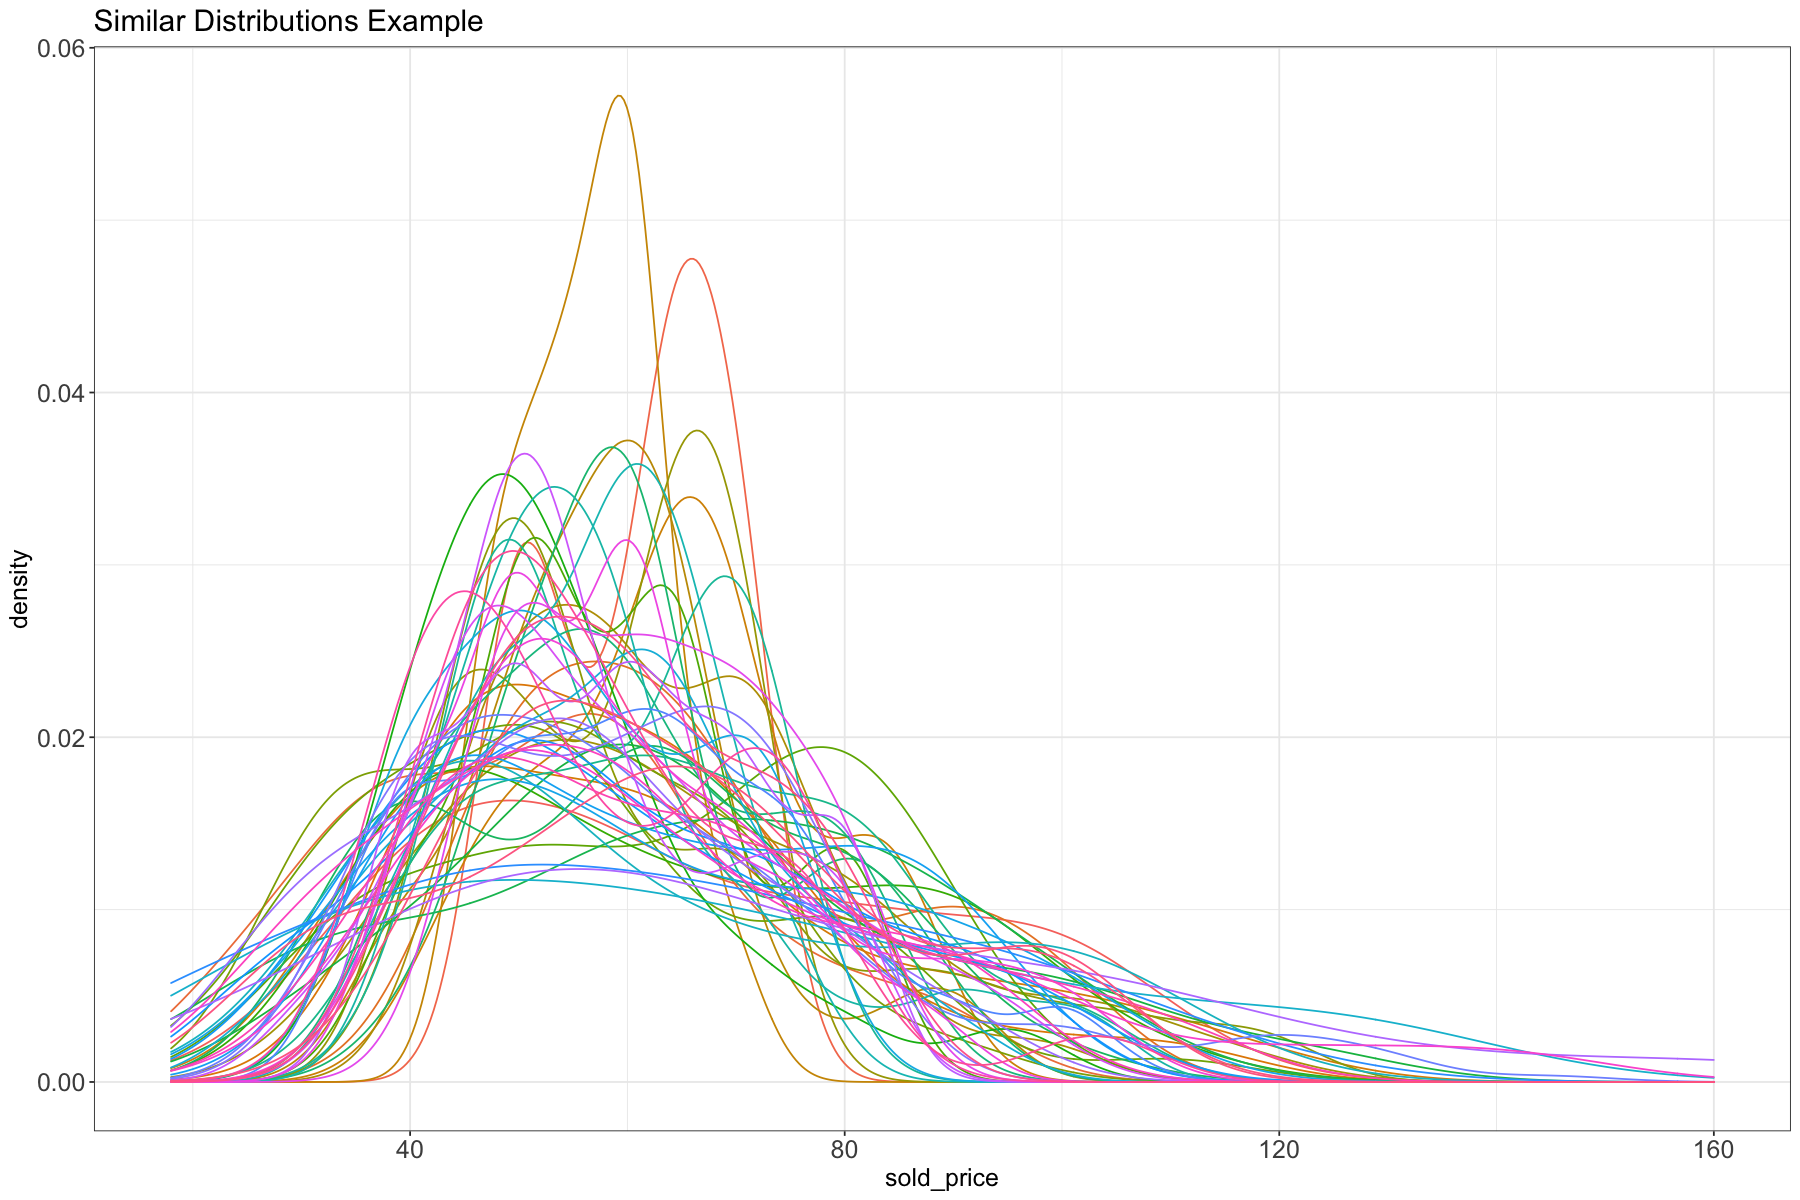

In [40]:
options(repr.plot.width=15, repr.plot.height=10)

a <- c('Cordless Drill',comb %>%
                         filter(ks >= 0.05) %>%
                         filter(grepl('DEWALT-Cordless Drill',V1)) %>% select(V2) %>% pull)

data %>%
 filter(CategoryDesc %in% a) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc), alpha = 0.2) +
 theme_bw() +
 ggtitle('Similar Distributions Example') +
 theme(axis.text.x  = element_text(size = 15),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none')

## Groups

Create groups using similar distributions

In [41]:
cats <- unique(c(comb$V1,comb$V2))

In [42]:
data.frame(CategoryDesc = NA,
           Group        = NA,
           Reference    = NA)  %>%
 filter(!is.na(NA)) -> groups

In [43]:
for(i in 1:length(cats)){    
    if(i == 1){
        
        aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
        aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
        g   <- c(cats[i], aux1, aux2)
        data.frame(CategoryDesc = g,
                   Group        = 1,
                   Reference    = cats[i]) -> df_aux
        
        } else {
        
        if(!(cats[i] %in% groups$CategoryDesc)){
            
            aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
            aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
            g   <- c(cats[i], aux1, aux2)
            last_group <- max(groups$Group)
            data.frame(CategoryDesc = g,
                       Group        = 1+last_group,
                       Reference    = cats[i]) -> df_aux
            
        }

    }
    
    groups <- rbind(groups,df_aux)
}

In [44]:
groups %>%
 distinct -> groups

In [45]:
groups %>% head

CategoryDesc                 Group Reference            
1 DEWALT-Cordless Drill        1     DEWALT-Cordless Drill
2 SINGER-Sewing Machine        1     DEWALT-Cordless Drill
3 NULL-Cordless Impact Drills  1     DEWALT-Cordless Drill
4 DEWALT-Electric Hammer Drill 1     DEWALT-Cordless Drill
5 craftsman-Gas Chain Saw      1     DEWALT-Cordless Drill
6 MATCO-Sockets (Standard)     1     DEWALT-Cordless Drill

## Solve Ties

Assign Categories in more than one group, to the most similar group.

This will be done calculating the average KS p-value for each CategoryDesc in more than 1 group, versus all the CategoryDesc in each group, and it will be assigned in the group with the highest p-value average

In [46]:
groups %>%
 group_by(CategoryDesc) %>%
 tally %>%
 filter(n > 1) %>%
 select(CategoryDesc) %>%
 pull -> reps

num_groups <- max(groups$Group)

In [47]:
for(i in 1:length(reps)){
    options(warn=-1)
    cat_rep <- reps[i]
    
    data.frame(cluster = NA,
               avg_ks  = NA) %>%
     filter(!is.na(cluster)) -> df
    
    for(j in 1:num_groups){
        categ     <- groups %>% filter(Group == j) %>% select(CategoryDesc) %>% pull
        num_categ <- length(categ)
        
        kss <- NA
        for(k in 1:num_categ){
            dist1 <- data %>% filter(CategoryDesc == categ[k]) %>% select(sold_price) %>% pull
            dist2 <- data %>% filter(CategoryDesc == cat_rep) %>% select(sold_price) %>% pull
            
            ks_p <- ks.test(dist1,dist2)
            
            kss <- c(kss,ks_p$p.value)
        }
        
        data.frame(cluster = j,
                   avg_ks  = mean(kss,na.rm = TRUE)) -> aux
        
        df <- rbind(df,aux)
    }
    
    
    df %>%
     arrange(desc(avg_ks)) %>%
     head(1) %>%
     select(cluster) %>%
     pull -> opt_cluster
    
    groups %>%
     filter(CategoryDesc != cat_rep) -> groups
    
    groups %>%
     filter(Group == opt_cluster) %>%
     select(Reference) %>%
     head(1) -> Ref
    
    data.frame(CategoryDesc = cat_rep,
               Group        = opt_cluster,
               Reference    = Ref) -> aux2
    
    groups <- rbind(groups, aux2) %>% arrange(Group)
    
}

In [48]:
write.csv(groups,file = 'groups_Manufacturer_ks.csv',row.names = FALSE)

Add the groups in all the data

In [49]:
data %>%
 left_join(groups, by = 'CategoryDesc') -> data

In [50]:
length(unique(groups$Group))

[1] 125

## Example similar Distributions

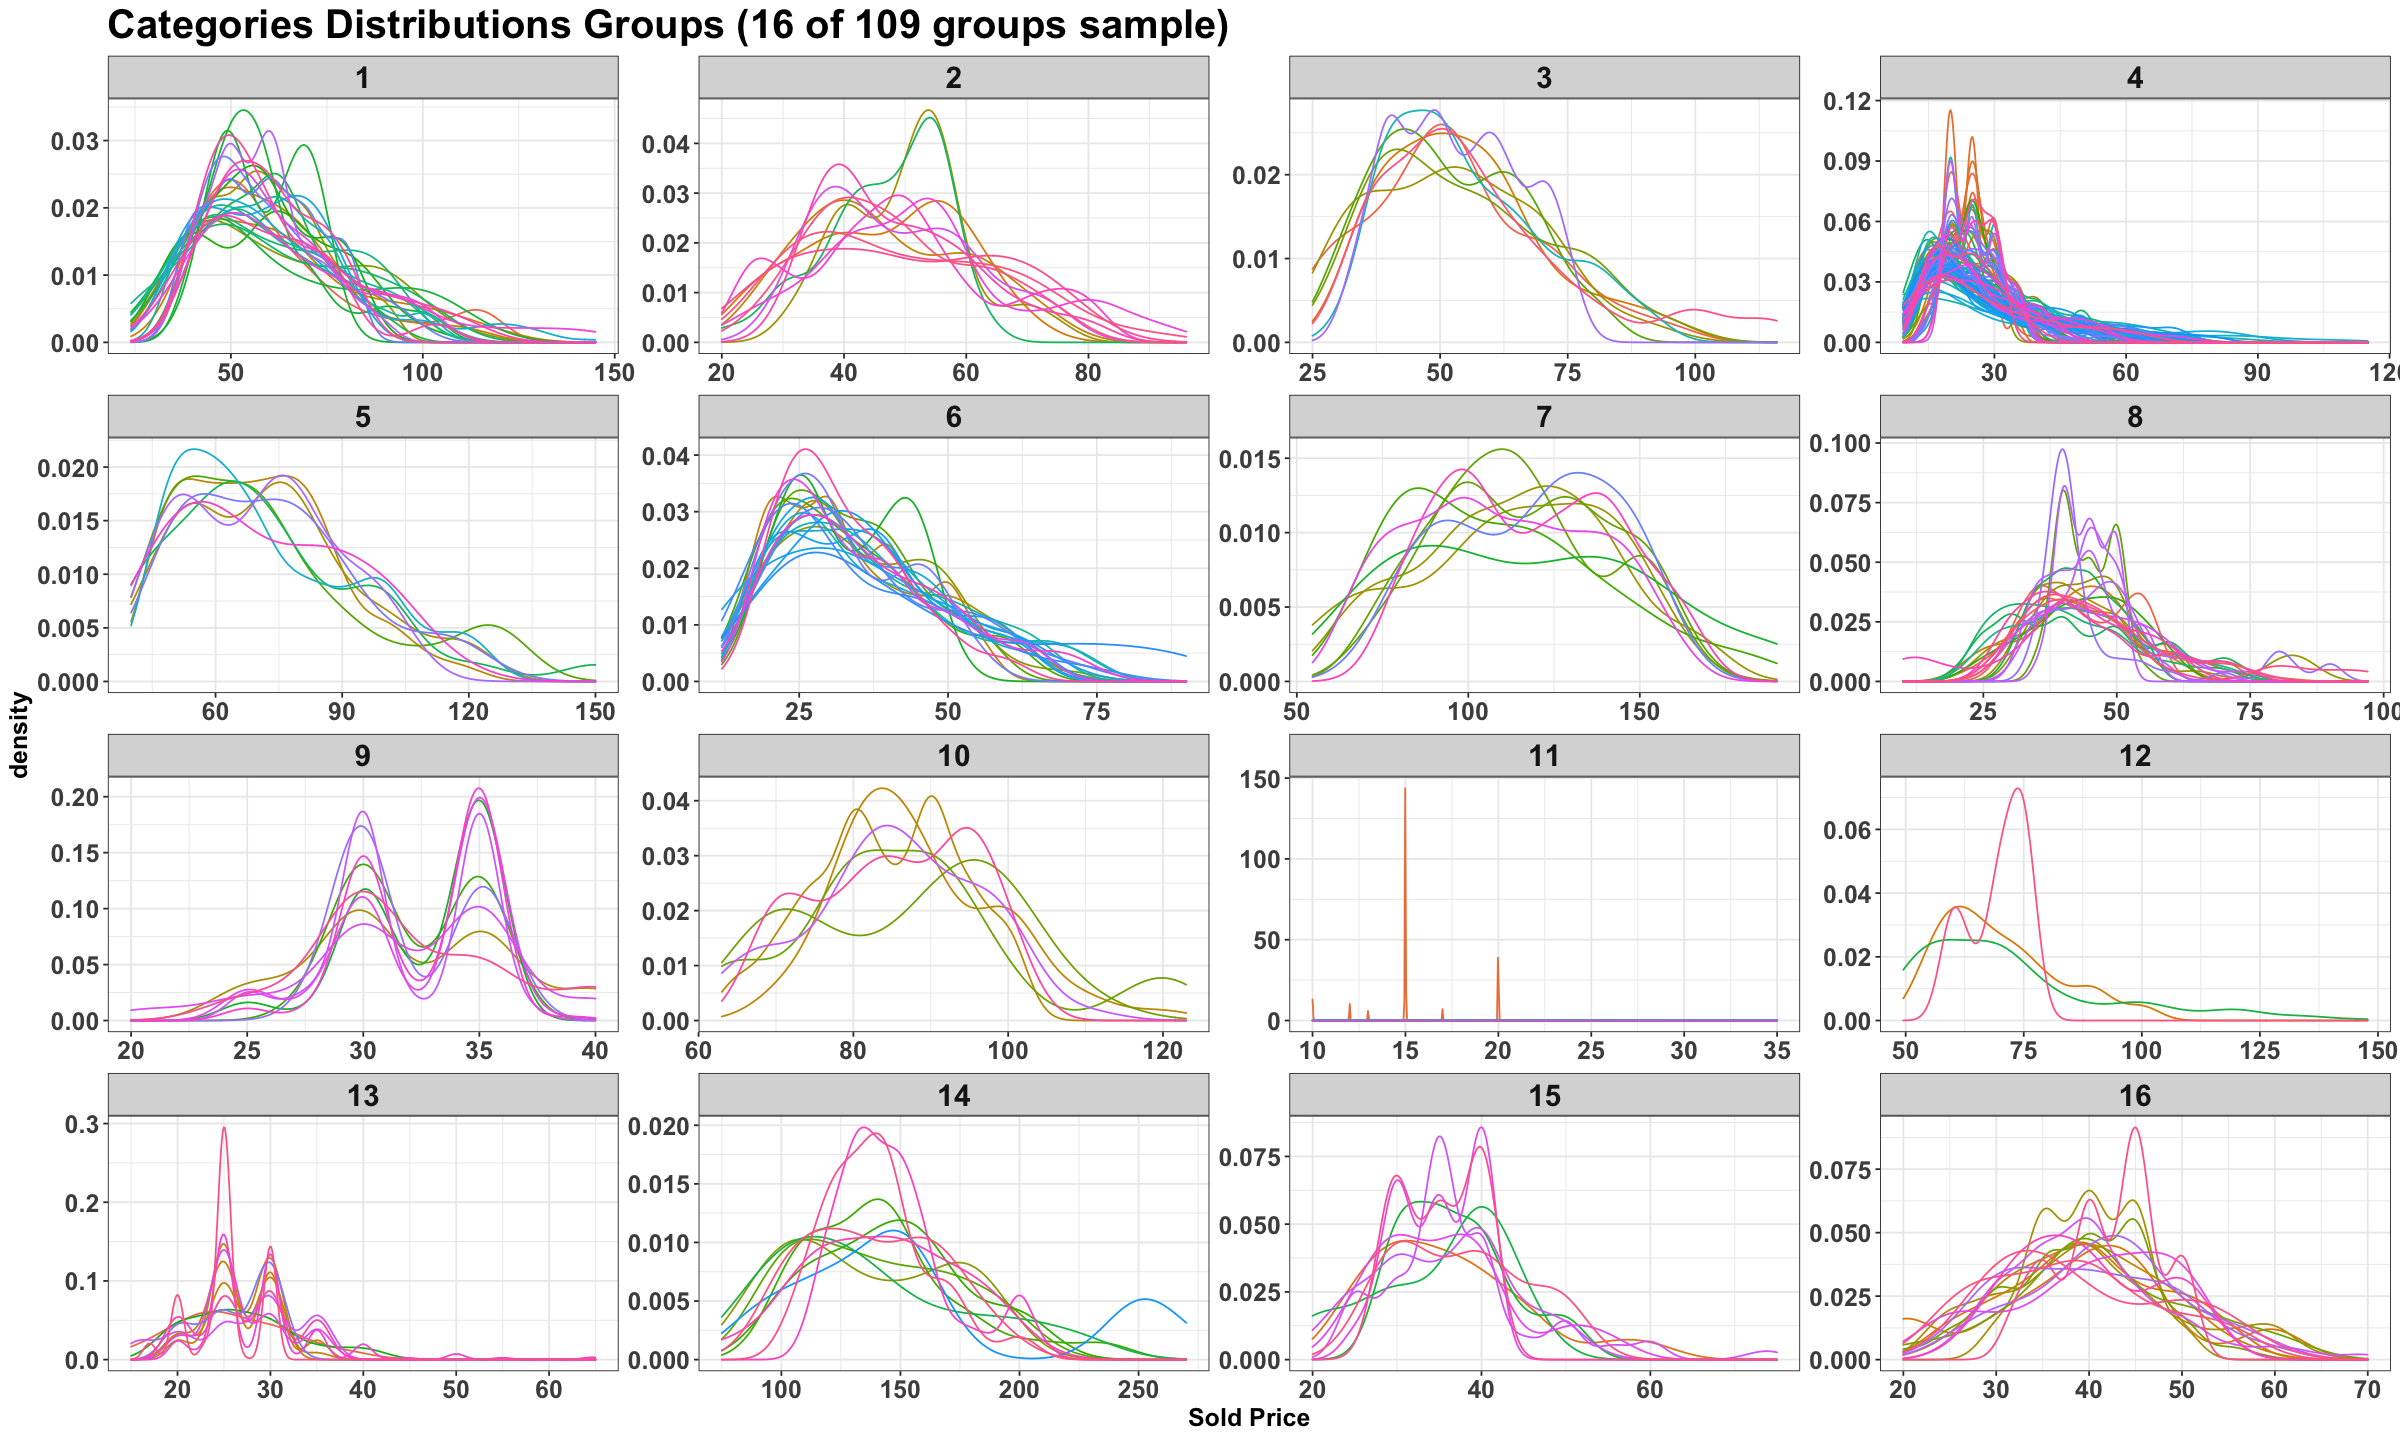

In [53]:
options(repr.plot.width=20, repr.plot.height=12)

data %>%
 filter(Group <= 16) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc)) +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       legend.position = 'none',
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 facet_wrap(~Group, scales = 'free') +
 ggtitle('Categories Distributions Groups (16 of 109 groups sample)') +
 xlab('Sold Price')
 

# Write data

Write item level data, with the group

In [35]:
getwd()

[1] "/Users/darias/Documents/Bucket_Pricing/Data_Out"

In [54]:
write.csv(data %>% select(-Reference), file = 'Item_Groups_Distribution_Manufacturer.csv', row.names = FALSE)

In [55]:
tail(groups)

CategoryDesc                   Group Reference    
1228 SAMSUNG-Sim Card               125   LG-DVD Player
1229 SLIME-Electric Compressor      125   LG-DVD Player
1230 SOUTHBEND-Fishing Rod And Reel 125   LG-DVD Player
1231 STANLEY-Level                  125   LG-DVD Player
1232 TEBCO-Fishing Rod And Reel     125   LG-DVD Player
1233 WAGNER-Heat Gun                125   LG-DVD Player

# Analysing right tail

Analyze if for the cluster 2, as an example, the right tail is because some items that really has high prices, or are employees errors

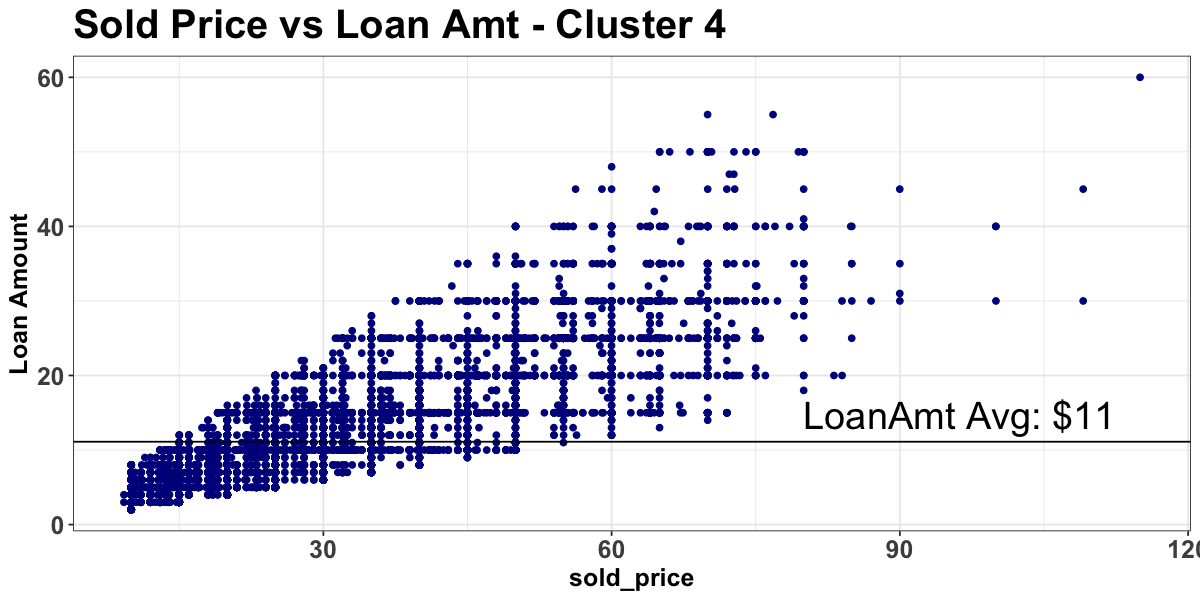

In [60]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(Group == 4) %>%
 select(cost) %>%
 pull %>%
 mean -> lam

data %>%
 filter(Group == 4) %>%
 ggplot() +
 geom_point(aes(x = sold_price, y = cost), colour = 'darkblue') +
 ggtitle('Sold Price vs Loan Amt - Cluster 4') +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       legend.position = 'none',
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 ylab('Loan Amount') +
 geom_hline(yintercept = lam) +
 annotate(geom  = 'text',
          x     = 80,
          y     = lam,
          label = paste0('LoanAmt Avg: $', round(lam)),
          vjust = -0.5,
          hjust = 0,
          size  = 8)

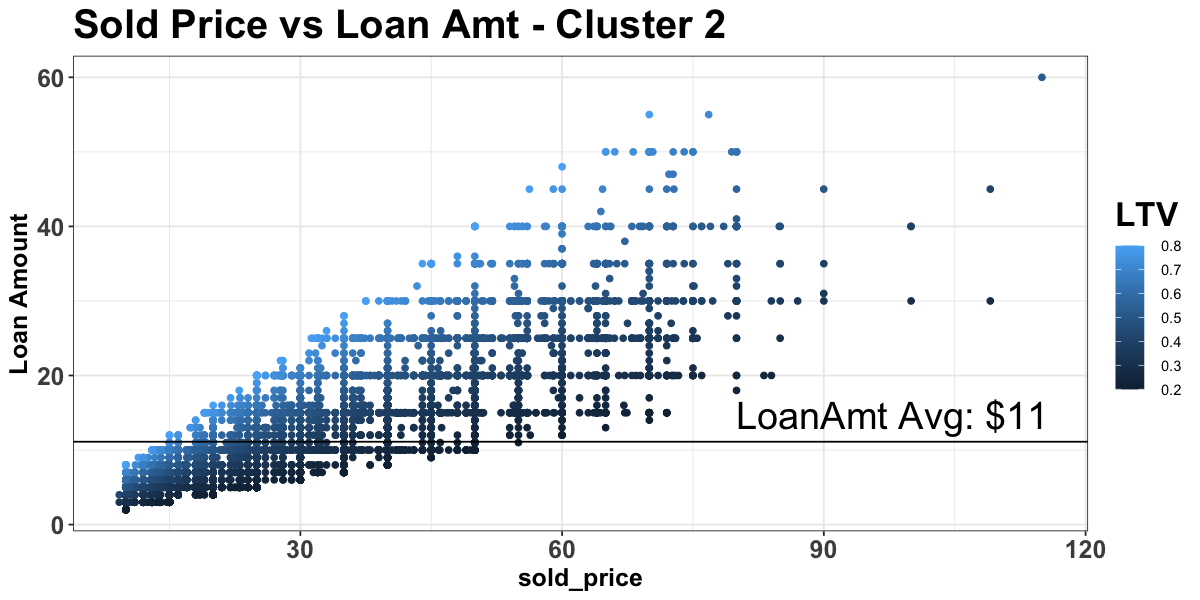

In [59]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(Group == 4) %>%
 select(cost) %>%
 pull %>%
 mean -> lam

data %>%
 filter(Group == 4) %>%
 ggplot() +
 geom_point(aes(x = sold_price, y = cost, colour = LTV)) +
 ggtitle('Sold Price vs Loan Amt - Cluster 2') +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 ylab('Loan Amount') +
 geom_hline(yintercept = lam) +
 annotate(geom  = 'text',
          x     = 80,
          y     = lam,
          label = paste0('LoanAmt Avg: $', round(lam)),
          vjust = -0.5,
          hjust = 0,
          size  = 8)

## Multimode group example

Analyze the reason of the multimode in some groups

Plot all the sold prices in the Group 9 as 1 distribution

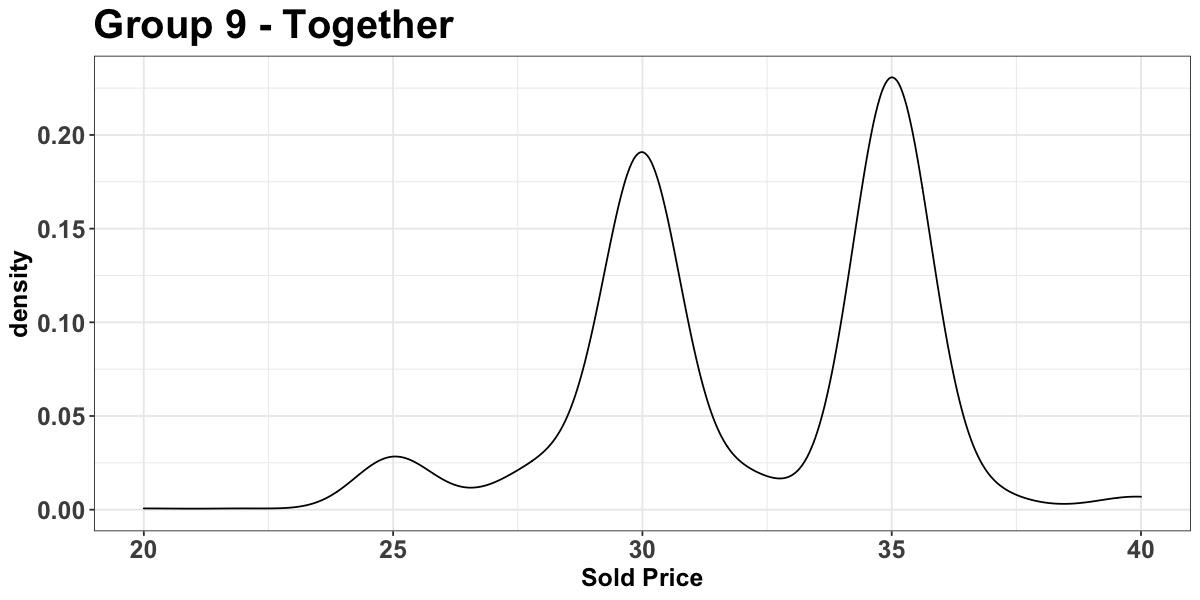

In [69]:
data %>%
 filter(Group == 9) %>%
 select(sold_price) %>%
 ggplot() +
 geom_density(aes(round(sold_price))) +
 theme_bw() +
 ggtitle('Group 9 - Together') +
 xlab('Sold Price') +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

See the modes

In [70]:
data %>%
 filter(Group == 9) %>%
 mutate(sold_price = round(sold_price)) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 head(5)

sold_price n  
1 35         357
2 30         292
3 25          43
4 28          30
5 32          26

See examples of item of Group 9 with sold price in the 2 modes

In [76]:
data %>%
 filter(Group == 9, round(sold_price) %in% c(30,35)) %>%
 distinct(Manufacturer)

Manufacturer
1 SONY        
2 SAMSUNG     
3 LG          
4 RYOBI       
5 PORTER CABLE
6 IBANEZ      
7 dewalt      
8 DEWALT

In [79]:
data %>%
 filter(Group == 9, round(sold_price) %in% c(30,35)) %>%
 mutate(Model_Number = paste0(Manufacturer,'-',Model_Number,'-',CategoryDesc_original)) %>%
 distinct(Model_Number) %>%
 head(10)

Model_Number                                    
1  SONY-BDP-BX2-Blu-Ray DVD Player                 
2  SONY-BDP-D3700-Blu-Ray DVD Player               
3  SAMSUNG-BD-P1590-Blu-Ray DVD Player             
4  SAMSUNG-BD-JM57-Blu-Ray DVD Player              
5  SAMSUNG-BD-J5100/ZA-Blu-Ray DVD Player          
6  LG-BPM25-Blu-Ray DVD Player                     
7  RYOBI-CSB125-Circular Saw (No Special Features) 
8  SAMSUNG-HT-H4500/ZA-Blu-Ray DVD Player          
9  PORTER CABLE-735-Regular Sawzall                
10 RYOBI-CSB133L-Circular Saw (No Special Features)

Manufacturers in mode and not mode

In [83]:
data %>%
 filter(Group == 9) %>%
 mutate(sold_price = round(sold_price),
        ind        = ifelse(sold_price %in% c(30,35), 'Item in mode', 'Item not in mode'),
         Model_Number = paste0(Manufacturer,'-',Model_Number,'-',CategoryDesc_original)) %>%
 group_by(ind,Model_Number) %>%
 summarise(cases = n()) %>%
 group_by(ind) %>%
 mutate(total = sum(cases),
        pct   = cases/total) %>%
 filter(pct >= 0.02)

ind              Model_Number                                      cases
1  Item in mode     RYOBI-CSB123-Circular Saw (No Special Features)   31   
2  Item in mode     RYOBI-CSB125-Circular Saw (No Special Features)   95   
3  Item in mode     RYOBI-CSB134L-Circular Saw (No Special Features)  15   
4  Item in mode     RYOBI-CSB135L-Circular Saw (No Special Features)  28   
5  Item in mode     RYOBI-D620H-Electric Hammer Drill                 22   
6  Item not in mode DEWALT-DWE6423-Corded Disc Sander                  5   
7  Item not in mode RYOBI-CSB123-Circular Saw (No Special Features)    9   
8  Item not in mode RYOBI-CSB125-Circular Saw (No Special Features)   18   
9  Item not in mode RYOBI-CSB135L-Circular Saw (No Special Features)  12   
10 Item not in mode RYOBI-CSB144LZ-Circular Saw (No Special Features)  6   
11 Item not in mode RYOBI-D620H-Electric Hammer Drill                  9   
   total pct       
1  649   0.04776579
2  649   0.14637904
3  649   0.02311248
4  649   0.04314330
5  649   0.03389831
6  162   0.03086420
7  162   0.05555556
8  162   0.11111111
9  162   0.07407407
10 162   0.03703704
11 162   0.05555556

# Buckets

The buckets will be calculated as the **mode** of the **Group distributions**.

Not will be considered all the **Groups** for this analysis, onlye those with this characteristics:
 - Distributions with significant modes: Distributions with modes with at least 20% of the cases
  -  With kow variance/Not too flat: Groups with Skewness >= 0.5
 - Multimode: Distributions with more than 1 mode

## Calculate modes

In [132]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 group_by(Group,sold_price) %>%
 summarise(n = n()) %>%
 ungroup %>%
 group_by(Group) %>%
 mutate(total = sum(n)) %>%
 ungroup %>%
 mutate(pct = n/total) %>%
 filter(pct >= 0.2) %>%
 group_by(Group) %>%
 mutate(mode_ind = dense_rank(-pct),
        mode_ind = paste0('mode',mode_ind)) %>%
 rename('mode' = 'sold_price') %>%
 select(Group,mode,mode_ind) %>%
 group_by(Group) %>%
 mutate(num_modes = n()) %>%
 group_by(Group) %>%
 mutate(num_modes = max(num_modes)) -> modes

head(modes,4)

Group mode mode_ind num_modes
1  9    30   mode2    2        
2  9    35   mode1    2        
3 11    15   mode1    2        
4 11    20   mode2    2

## Calculate Skewness

In [133]:
skewness=function(x) {
m3=mean((x-mean(x))^3)
skew=m3/(sd(x)^3)
skew}

In [134]:
data %>%
 group_by(Group) %>%
 summarise(sk = skewness(sold_price)) -> sk_df

## Get buckets

With these rules:
 - If it is multimode, the buckets will be the modes
 - If it not multimode, and has skewness >= 0.5, and has a significant mode (>= 20%), then the bucket will be the mode

In [137]:
sk_df %>%
 left_join(modes,by='Group') %>%
 filter((num_modes==1 | sk >= 0.05) | num_modes > 1) %>%
 filter(!is.na(mode)) -> groups_buckets

Add the Manufacturer for the Groups

In [144]:
data %>%
 distinct(Group, CategoryDesc) -> CD

groups_buckets %>%
 left_join(CD,by='Group') %>%
 select(-sk) -> Manufacturer_Buckets

Write Data

In [145]:
write.csv(Manufacturer_Buckets, file = 'Buckets_Manufacturer.csv', row.names = FALSE)

In [182]:
unique(data$CategoryDesc) %>% length

[1] 1233

In [181]:
unique(Manufacturer_Buckets$CategoryDesc) %>% length

[1] 547

In [184]:
round(547/1233,3)*100

[1] 44.4

In [179]:
Manufacturer_Buckets %>%
 filter(Group == 80)

Group mode mode_ind num_modes CategoryDesc                               
1  80    50   mode3    3         RYOBI-Pole Saw                             
2  80    50   mode3    3         MURRAY-Gas Weed Eater - Straight Shaft     
3  80    50   mode3    3         HOMELITE-Gas Weed Eater - Straight Shaft   
4  80    50   mode3    3         BOLENS-Gas Weed Eater - Straight Shaft     
5  80    50   mode3    3         CRAFTSMAN-Compound Miter Saw               
6  80    50   mode3    3         SONY-Car Stereo Amplifier                  
7  80    50   mode3    3         HYPER TOUGH-Gas Weed Eater - Straight Shaft
8  80    50   mode3    3         hyper tough-Gas Weed Eater - Straight Shaft
9  80    50   mode3    3         BOSCH-Circular Saw (No Special Features)   
10 80    55   mode2    3         RYOBI-Pole Saw                             
11 80    55   mode2    3         MURRAY-Gas Weed Eater - Straight Shaft     
12 80    55   mode2    3         HOMELITE-Gas Weed Eater - Straight Shaft   
13 80    55   mode2    3         BOLENS-Gas Weed Eater - Straight Shaft     
14 80    55   mode2    3         CRAFTSMAN-Compound Miter Saw               
15 80    55   mode2    3         SONY-Car Stereo Amplifier                  
16 80    55   mode2    3         HYPER TOUGH-Gas Weed Eater - Straight Shaft
17 80    55   mode2    3         hyper tough-Gas Weed Eater - Straight Shaft
18 80    55   mode2    3         BOSCH-Circular Saw (No Special Features)   
19 80    60   mode1    3         RYOBI-Pole Saw                             
20 80    60   mode1    3         MURRAY-Gas Weed Eater - Straight Shaft     
21 80    60   mode1    3         HOMELITE-Gas Weed Eater - Straight Shaft   
22 80    60   mode1    3         BOLENS-Gas Weed Eater - Straight Shaft     
23 80    60   mode1    3         CRAFTSMAN-Compound Miter Saw               
24 80    60   mode1    3         SONY-Car Stereo Amplifier                  
25 80    60   mode1    3         HYPER TOUGH-Gas Weed Eater - Straight Shaft
26 80    60   mode1    3         hyper tough-Gas Weed Eater - Straight Shaft
27 80    60   mode1    3         BOSCH-Circular Saw (No Special Features)

# Examples

## No Bucket example

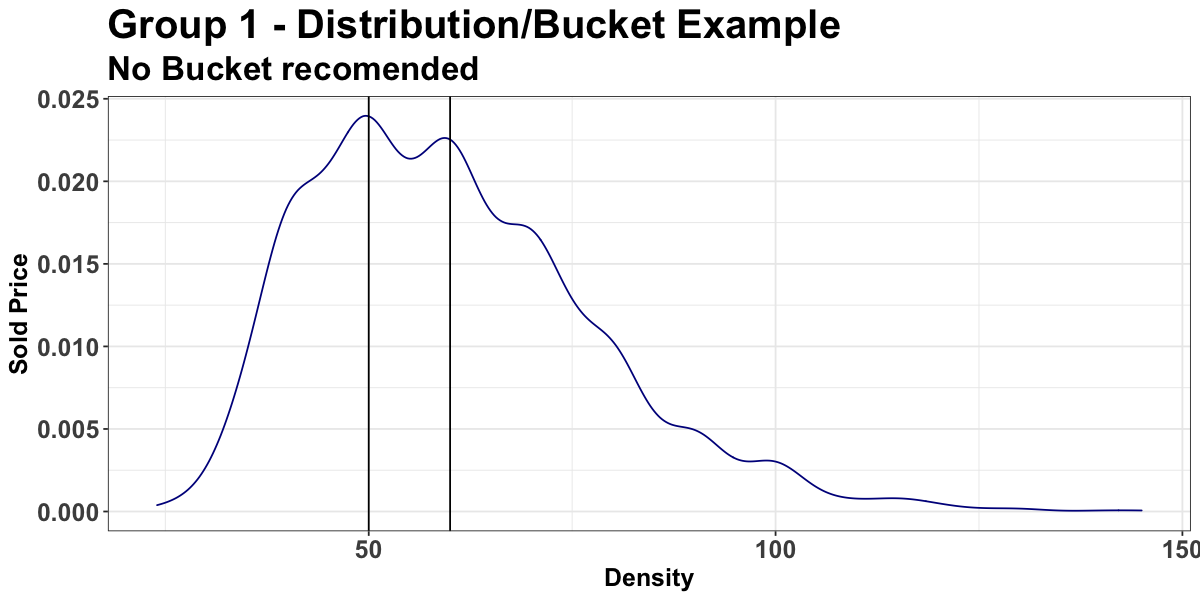

In [170]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 1) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

a %>%
 filter(rank == 2) %>%
 select(sold_price) %>%
 pull -> m2

data %>%
 filter(Group == 1) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 1 - Distribution/Bucket Example', subtitle = 'No Bucket recomended') +
 theme_bw() +
 ylab('Sold Price') +
 xlab('Density') +
 geom_vline(xintercept = m1) +
 geom_vline(xintercept = m2) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## One Bucket Example

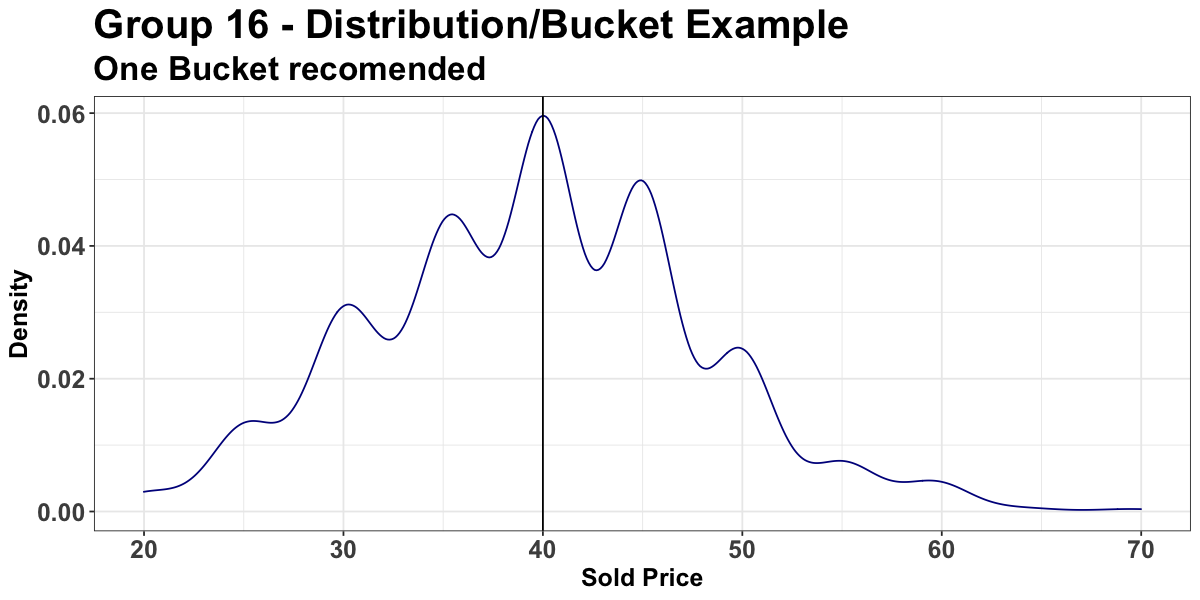

In [175]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 16) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

data %>%
 filter(Group == 16) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 16 - Distribution/Bucket Example', subtitle = 'One Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = m1) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

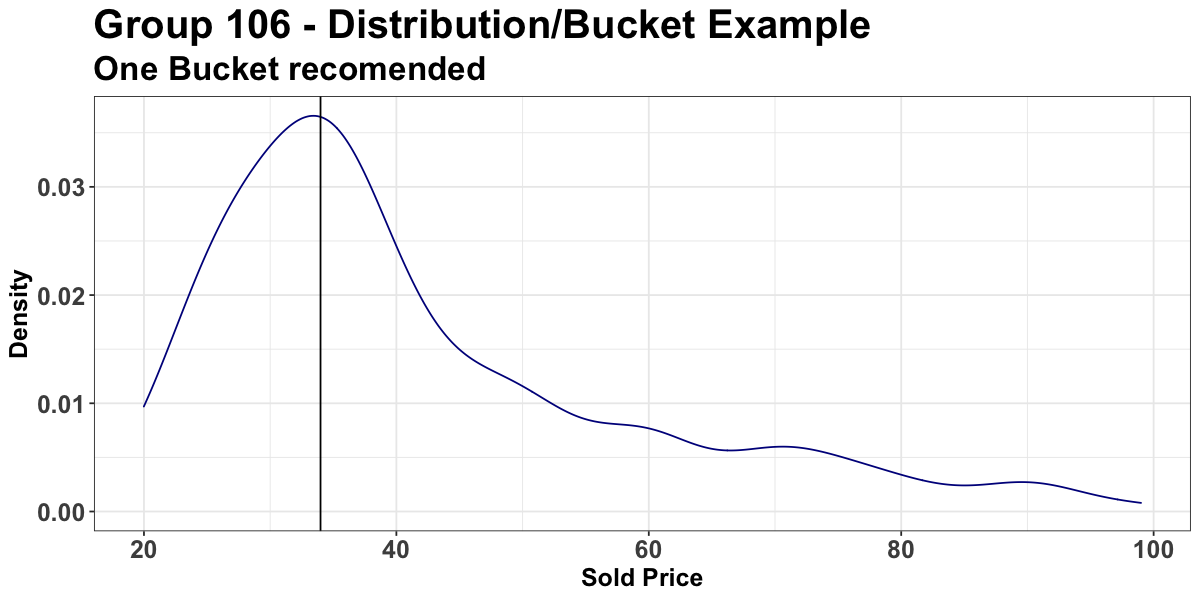

In [176]:
data %>%
 filter(Group == 106) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 106 - Distribution/Bucket Example', subtitle = 'One Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 33.99) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## Multiple Bucket Example

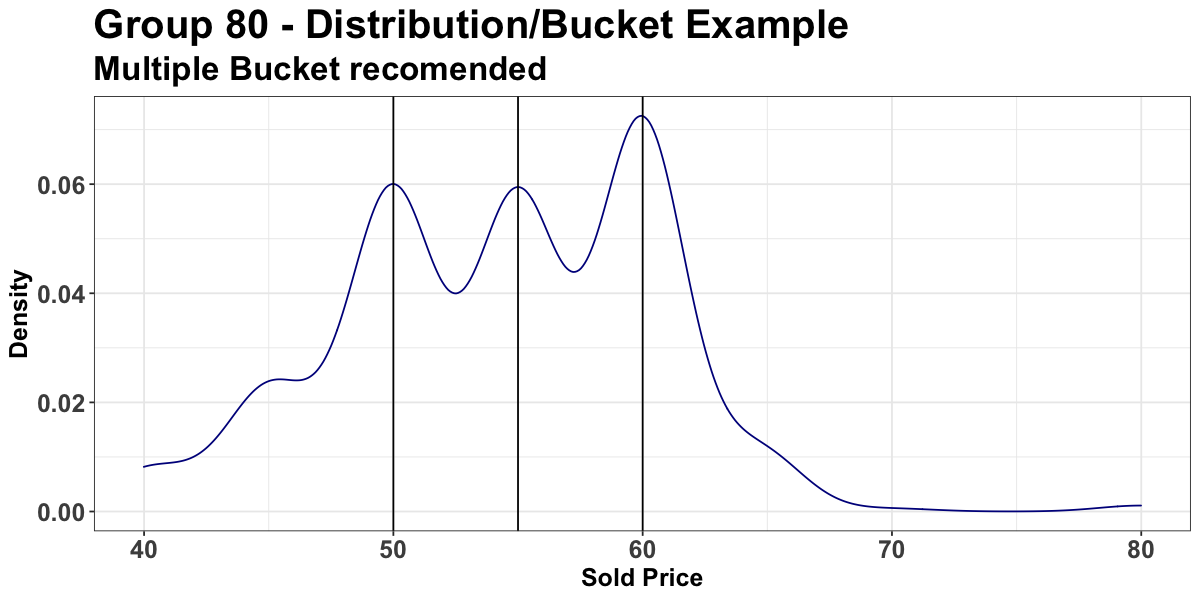

In [177]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 80) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

a %>%
 filter(rank == 2) %>%
 select(sold_price) %>%
 pull -> m2

a %>%
 filter(rank == 3) %>%
 select(sold_price) %>%
 pull -> m3

data %>%
 filter(Group == 80) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 80 - Distribution/Bucket Example', subtitle = 'Multiple Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = m1) +
 geom_vline(xintercept = m2) +
 geom_vline(xintercept = m3) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))